In [ ]:
# Import necessary libraries
import torch
import numpy as np
from networks import BayesianNetwork, MLP
from config import RegConfig
from utils import PrepareData, create_data_reg, create_regression_plot
from torch.utils.data import DataLoader
from tqdm import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Bayesian Neural Network for Regression Task
class BNN_Regression():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.noise_tol = parameters['noise_tolerance']
        self.lr = parameters['lr']
        self.init_net(parameters)
    
    # Initialize the Bayesian Neural Network with given parameters
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init']
        }
        # Create the Bayesian Network model
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=500, gamma=0.5)
        print("BNN Parameters: ")
        print(f'batch size: {self.batch_size}, x shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, mu_init: {parameters["mu_init"]}, rho_init: {parameters["rho_init"]}, prior_init: {parameters["prior_init"]}, lr: {self.lr}')

    # Define the training step
    def train_step(self, train_data):
        self.net.train()
        for idx, (x, y) in enumerate(train_data):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1) # This allows to distribute the KL cost non-uniformly among the batches
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples, sigma=self.noise_tol)
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()

    # Evaluate the model on the test set
    def evaluate(self, x_test):
        self.net.eval()
        with torch.no_grad():
            y_test = np.zeros((self.test_samples, x_test.shape[0]))
            for s in range(self.test_samples):
                tmp = self.net(x_test.to(device)).detach().cpu().numpy()
                y_test[s,:] = tmp.reshape(-1)
            return y_test

In [ ]:
# Regression using Multi-Layer Perceptron (MLP)
class MLP_Regression():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.init_net()
    
    # Initialize the MLP with given parameters
    def init_net(self):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment
        }
        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print("MLP Parameters: ")
        print(f'batch size: {self.batch_size}, input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    # Define the training step
    def train_step(self, train_data):
        self.net.train()
        for _, (x, y) in enumerate(train_data):
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = torch.nn.functional.mse_loss(self.net(x), y, reduction='sum')
            self.loss_info.backward()
            self.optimiser.step()

    # Evaluate the model on the test set
    def evaluate(self, x_test):
        self.net.eval()
        with torch.no_grad():
            y_test = self.net(x_test.to(device)).detach().cpu().numpy()
            return y_test

BNN Parameters: 
batch size: 128, x shape: 1, hidden units: 400, output shape: 1, mu_init: [-0.2, 0.2], rho_init: [-4, -3], prior_init: [0.5, 0, -6], lr: 0.001
Initialising training on cuda...


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Evaluating and generating plots...


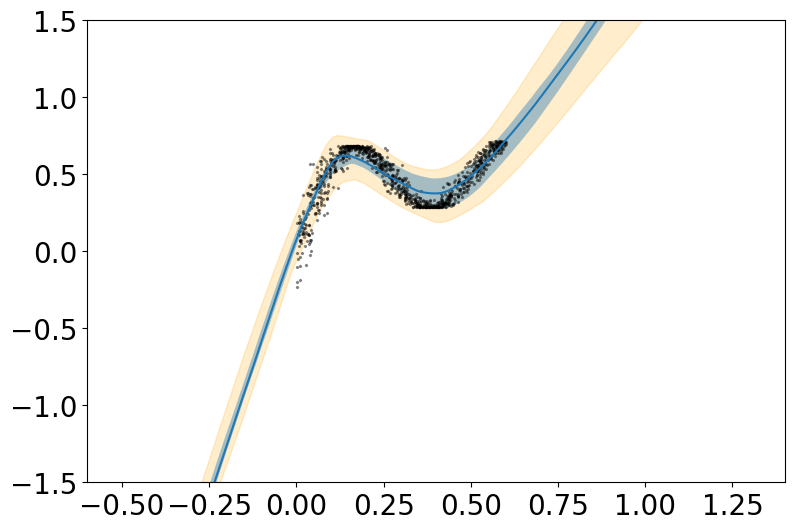

In [ ]:
# Regression Trainer Function for Bayesian Backpropagation
def reg_BNN_trainer():
    config = RegConfig
    X, Y = create_data_reg(train_size=config.train_size)
    train_loader = PrepareData(X, Y)
    train_loader = DataLoader(train_loader, batch_size=config.batch_size, shuffle=True)

    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'batch_size': config.batch_size,
        'num_batches': len(train_loader),
        'x_shape': X.shape[1],
        'y_shape': Y.shape[1],
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'noise_tolerance': config.noise_tolerance,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    model = BNN_Regression('bnn_regression', {**params})
    epochs = config.epochs
    print(f"Initialising training on {device}...")

    # Training
    for epoch in tqdm(range(epochs)):
        model.train_step(train_loader)
        model.scheduler.step()

    # Evaluate
    print("Evaluating and generating plots...")

    # Generate test points
    x_test = torch.linspace(-2., 2, config.num_test_points).reshape(-1, 1)
    y_test = model.evaluate(x_test)
    
    # Create regression plot
    create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)

reg_BNN_trainer()

MLP Parameters: 
batch size: 128, input shape: 1, hidden units: 400, output shape: 1, lr: 0.001
Initialising training on cuda...


100%|██████████| 50/50 [00:00<00:00, 59.82it/s]


Evaluating and generating plots...


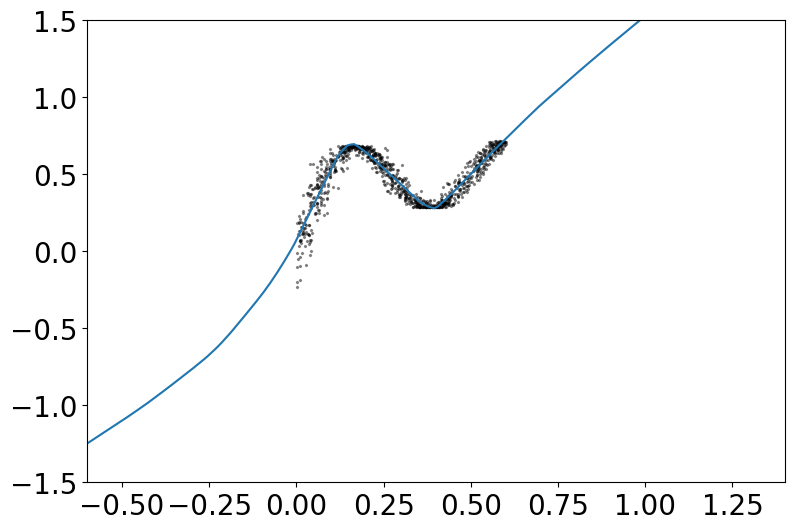

In [ ]:
# Regression Trainer Function for MLP
def reg_MLP_trainer():
    config = RegConfig
    X, Y = create_data_reg(train_size=config.train_size)
    train_loader = PrepareData(X, Y)
    train_loader = DataLoader(train_loader, batch_size=config.batch_size, shuffle=True)

    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'batch_size': config.batch_size,
        'num_batches': len(train_loader),
        'x_shape': X.shape[1],
        'y_shape': Y.shape[1],
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'noise_tolerance': config.noise_tolerance,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    model = MLP_Regression('mlp_regression', {**params})
    epochs = config.epochs
    print(f"Initialising training on {device}...")

    # Training
    for epoch in tqdm(range(epochs)):
        model.train_step(train_loader)
        model.scheduler.step()
      
    # Evaluate
    print("Evaluating and generating plots...")
    # Generate test points
    x_test = torch.linspace(-2., 2, config.num_test_points).reshape(-1, 1)
    y_test = model.evaluate(x_test)
    # Create regression plot
    create_regression_plot(x_test.cpu().numpy(), y_test.reshape(1, -1), train_loader) #per mlp regression
   
reg_MLP_trainer()